<a href="https://colab.research.google.com/github/NicoAN42/SKRPSI/blob/main/ncn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#mount dataset
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import tensorflow
from tensorflow.keras.layers import Conv2D, Input, concatenate, Activation, InputLayer, Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU,ReLU, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.activations import softmax,sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,SpatialDropout2D,GaussianDropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1,l2
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import os
import random
import shutil

In [39]:
CLASS = 3
#sourcepath isi semua data train, folder valid kosongin datanya sisai folder classnya
sourcePath = '/content/drive/MyDrive/Colab Notebooks/Dataset Simsalabim'
train_path = '/content/drive/MyDrive/Colab Notebooks/Dataset Simsalabim/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Dataset Simsalabim/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset Simsalabim/test'

#nico

In [40]:
classLabels =['covid','normal', 'pneumonia']

In [41]:
model = Sequential()

In [42]:
model.add(layers.InputLayer(input_shape=(256, 256, 3)))

In [43]:
input_Layer=model.add(layers.InputLayer(input_shape=(256, 256, 3)))

In [44]:
#Layer 1
model.add(layers.Conv2D(32, (3,3), padding='same', name='conv_1', activation = 'relu'))
model.add(layers.BatchNormalization(name='norm_1'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides= 2))


In [45]:
#Layer 2
model.add(layers.Conv2D(64, (3,3), padding='same', name='conv_2', activation = 'relu')),
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization(name='norm_2'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))

In [46]:
# Layer 3
model.add(layers.Conv2D(64, (3,3), padding='same', name='conv_3', activation = 'relu'))
model.add(layers.BatchNormalization(name='norm_3'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))


In [47]:
# Layer 4
model.add(layers.Conv2D(128, (3,3), padding='same', name='conv_4', activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(name='norm_4'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))


In [48]:
# Layer 5
model.add(layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(name='norm_5'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))


In [65]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3,Activation('softmax')))
model.output_shape

(None, 3)

In [66]:
output = model.output_shape

In [67]:
print(input_Layer)

None


In [68]:
#initial_learning_rate=0.0001

In [69]:
#lr_schedule = ExponentialDecay(
#   initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
#)


In [70]:
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [71]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [72]:
print(model.summary())
print(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        multiple                  0         
                                                                 
 conv_1 (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 norm_1 (BatchNormalization)  (None, 256, 256, 32)     128       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv_2 (Conv2D)             (None, 128, 128, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 64)      0         
                                                      

In [73]:
X = []
Y = []
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        

In [74]:
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(sourcePath+'/'+source+'/'+label+'/', 
                               sourcePath+'/'+dest+'/'+label+'/', 
                               splitRate)
        

In [75]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(sourcePath+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [76]:
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

skf = StratifiedKFold(n_splits=5
                      , shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0

['COVID(333).png' 'COVID(771).png' 'COVID(754).png' ...
 'person1409_bacteria_3585.jpeg' 'person1398_virus_2401.jpeg'
 'person1413_bacteria_3615.jpeg']
[0 0 0 ... 2 2 2]


Results for fold 1
Found 1917 images belonging to 3 classes.
Found 378 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Epoch 1/100
30/30 - 459s - loss: 1.0937 - accuracy: 0.8644 - val_loss: 1.2964 - val_accuracy: 0.6534 - 459s/epoch - 15s/step
Epoch 2/100
30/30 - 31s - loss: 0.1323 - accuracy: 0.9572 - val_loss: 0.8526 - val_accuracy: 0.5741 - 31s/epoch - 1s/step
Epoch 3/100
30/30 - 30s - loss: 0.0898 - accuracy: 0.9677 - val_loss: 0.7000 - val_accuracy: 0.7116 - 30s/epoch - 990ms/step
Epoch 4/100
30/30 - 30s - loss: 0.0919 - accuracy: 0.9671 - val_loss: 0.2078 - val_accuracy: 0.9471 - 30s/epoch - 1s/step
Epoch 5/100
30/30 - 30s - loss: 0.1410 - accuracy: 0.9583 - val_loss: 0.2402 - val_accuracy: 0.9206 - 30s/epoch - 1s/step
Epoch 6/100
30/30 - 30s - loss: 0.0603 - accuracy: 0.9791 - val_loss: 0.1767 - val_accuracy: 0.9418 - 30s/epoch - 993ms/step
Epoch 7/100
30/30 - 30s - loss: 0.0514 - accuracy: 0.9802 - val_loss: 0.4023 - val_accuracy: 0.8571 - 30s/epoch - 1s

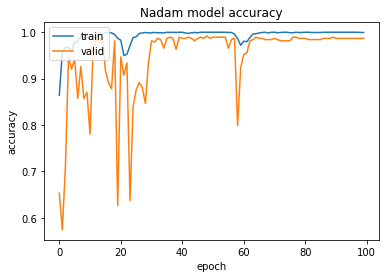

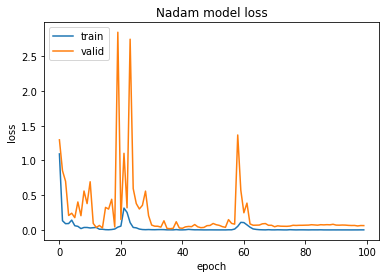

7/7 [==============================] - 5s 717ms/step
[0 2 1 1 2 0 2 2 0 0 1 1 2 2 0 0 1 0 1 2 1 2 2 1 0 1 2 1 1 2 2 2 2 0 0 2 2
 2 0 0 1 0 1 0 0 1 1 1 1 2 1 2 2 2 1 2 0 0 0 1 0 0 1 0 2 0 1 0 1 0 1 0 0 0
 1 2 0 2 0 0 0 1 2 0 1 1 0 1 0 0 2 0 2 1 1 1 1 0 0 0 1 0 2 1 2 1 0 1 0 0 2
 1 0 1 1 0 2 0 0 1 2 1 2 2 2 1 1 2 0 0 2 2 2 1 2 0 1 1 2 2 2 1 0 1 1 0 1 1
 2 2 1 1 2 0 1 0 1 0 1 0 2 1 2 1 0 1 2 1 1 1 1 0 1 0 2 2 2 1 2 0 2 1 0 0 1
 0 1 2 1 2 0 0 0 2 0 1 0 1 1 0 0 0 2 1 1 0 1 1 1 1 0 2 2 1 0 1 2 1 1 2 0 0
 2 1 0 1 0 0 0 2 1 2 1 0 2 1 0 1 1 1 1 2 1 2 0 0 1 0 0 0 2 0 2 0 1 2 2 1 2
 0 0 0 2 0 2 0 1 2 1 1 1 1 2 2 1 2 1 1 0 0 1 1 2 2 1 2 0 1 2 0 2 1 2 2 1 2
 1 0 2 1 1 1 0 2 1 2 0 0 2 2 2 0 2 1 1 2 0 1 2 2 0 1 0 0 1 1 0 2 2 1 1 1 2
 0 0 1 0 2 0 0 2 0 1 0 2 1 1 2 1 2 2 2 0 1 0 2 2 1 1 2 2 1 1 0 0 0 0 2 0 1
 0 2 2 2 1 2 2 2 0 2 1 2 0 2 0 1 0 2 1 1 0 2 1 1 2 1 1 0 1 2 1 2 2 2 1]
***Performance on Validation data***
Accuracy  : 0.38271604938271603
Precision : 0.38343089173653955
f1Score : 0.382710079518

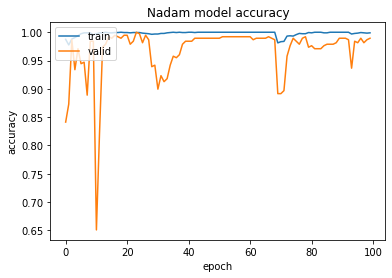

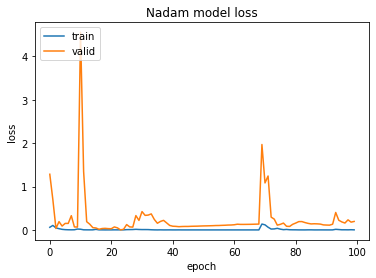

7/7 [==============================] - 5s 633ms/step
[0 0 0 0 1 1 0 2 0 2 0 1 2 0 1 2 1 0 1 1 0 1 1 1 0 2 2 1 2 0 2 2 1 1 0 0 0
 1 1 1 1 2 1 0 2 1 1 2 0 2 1 0 1 0 0 1 0 2 0 2 0 2 2 2 1 1 2 0 1 1 0 0 0 0
 2 1 2 0 0 0 1 2 1 0 2 1 2 1 0 2 1 0 0 1 1 1 0 1 1 0 2 2 2 0 2 0 2 1 2 1 1
 1 2 1 2 1 0 1 1 1 0 2 0 0 0 1 2 2 0 2 1 2 0 2 1 1 0 2 1 1 1 0 2 0 0 0 2 0
 1 1 1 2 2 2 2 0 1 1 1 2 1 0 2 2 0 0 0 2 0 2 2 1 1 1 0 2 0 2 1 0 0 0 1 2 2
 1 0 1 1 0 2 0 0 1 1 2 1 1 1 2 2 0 1 2 2 1 1 0 2 2 1 1 1 1 0 2 2 0 1 2 1 1
 1 1 1 2 1 2 2 0 2 0 0 2 1 0 2 1 1 0 2 0 1 2 1 2 1 2 0 2 1 1 1 0 1 0 1 2 0
 0 2 2 0 2 1 0 1 1 2 2 1 0 2 2 0 1 1 2 1 2 0 0 2 1 0 1 0 2 1 1 2 1 1 2 1 2
 0 0 0 0 0 2 2 0 1 2 1 0 1 0 1 2 1 0 1 1 2 0 2 2 1 1 2 2 0 2 0 1 2 0 0 2 1
 0 0 2 0 0 2 2 1 2 2 2 1 0 1 1 2 1 0 0 2 0 1 1 1 0 0 0 0 2 1 1 0 0 1 0 0 1
 0 1 0 2 0 2 2 1 2 2 2 1 1 0 2 2 2 2 2 0 0 1 2 0 1 2 0 1 0 2 1 1 1 2 1]
***Performance on Validation data***
Accuracy  : 0.3530864197530864
Precision : 0.3530559510625956
f1Score : 0.35272942187835

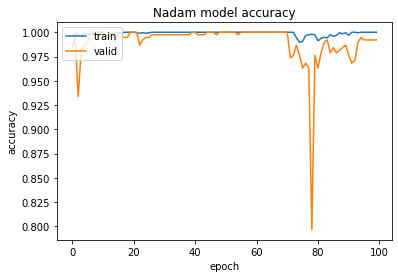

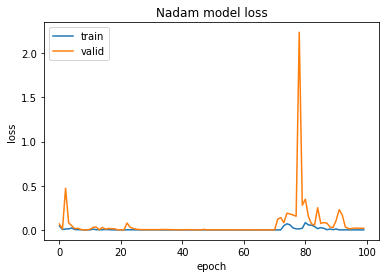

7/7 [==============================] - 5s 648ms/step
[2 2 2 1 1 0 1 1 0 1 0 1 2 2 2 0 2 0 2 1 2 1 1 0 0 1 2 0 1 0 0 1 0 2 2 2 0
 2 2 1 1 0 2 0 2 2 2 0 2 1 2 2 0 2 1 1 1 2 1 0 1 1 2 0 1 1 1 0 2 0 0 2 2 2
 1 1 0 2 2 1 2 1 2 0 2 1 2 1 1 0 0 1 0 1 2 0 2 2 2 2 0 0 0 1 0 1 1 1 0 0 0
 2 0 0 1 2 0 1 1 2 1 1 2 2 1 2 0 2 0 1 0 2 2 0 1 2 0 1 0 0 1 1 0 1 1 0 2 0
 2 1 0 2 2 2 1 1 0 2 2 0 2 2 2 0 1 1 2 1 2 0 1 1 0 0 1 2 1 2 1 1 0 1 0 0 0
 2 0 2 1 0 1 2 1 0 1 1 0 2 0 2 1 0 0 1 0 2 1 0 1 0 1 1 1 0 1 1 0 0 2 1 1 0
 1 2 0 2 0 2 1 2 1 1 2 2 0 0 0 0 0 0 2 2 1 2 1 0 2 0 2 1 1 1 2 0 2 0 2 0 1
 0 0 2 0 0 2 0 0 2 2 2 0 0 2 1 1 0 2 1 0 2 2 1 0 0 0 1 0 2 1 0 1 1 2 1 0 1
 2 0 0 1 2 0 2 2 1 1 2 0 0 0 0 2 1 0 0 0 1 0 1 1 2 2 1 0 2 0 1 2 1 0 1 1 1
 2 2 0 1 2 2 1 1 1 0 1 1 0 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 2 2 0 2
 1 0 2 0 1 2 2 1 2 2 1 1 2 0 0 1 1 1 1 0 2 1 2 0 0 0 0 2 2 1 0 2 0 1 1]
***Performance on Validation data***
Accuracy  : 0.3037037037037037
Precision : 0.30351248564867966
f1Score : 0.3034509534583

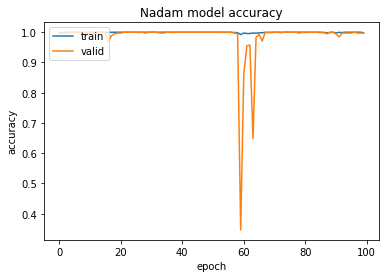

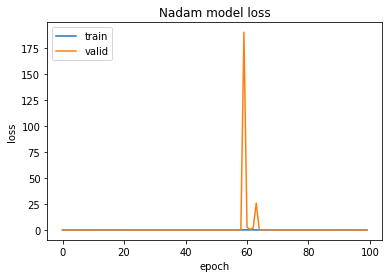

7/7 [==============================] - 5s 633ms/step
[1 0 2 1 0 2 0 1 1 0 2 0 1 2 1 0 0 2 1 2 0 2 0 1 1 1 2 1 1 0 1 1 2 1 1 1 1
 0 0 1 1 2 1 0 2 1 0 1 2 1 2 2 1 1 0 2 1 0 0 1 0 0 1 1 1 0 2 1 1 0 1 0 0 1
 1 1 0 2 1 1 0 2 2 2 0 2 1 1 0 2 0 0 0 0 2 2 2 0 1 1 0 0 0 1 2 0 0 0 2 1 0
 1 2 2 2 0 2 0 1 0 1 1 2 1 1 2 0 2 2 1 1 0 1 0 1 2 0 1 1 0 0 2 2 1 1 1 2 0
 1 0 1 0 0 0 2 0 1 1 1 2 1 2 2 0 1 2 1 0 0 0 1 1 2 1 1 1 1 0 2 0 1 1 1 0 1
 2 2 0 2 1 1 0 2 2 1 0 1 2 2 2 0 0 1 0 0 1 2 0 1 1 1 0 1 1 1 1 0 2 2 0 0 0
 2 0 2 0 1 2 2 2 1 1 2 1 1 0 0 0 2 0 2 0 0 0 1 1 2 0 2 2 2 0 0 1 2 2 2 2 1
 2 0 2 1 2 1 0 2 1 1 1 2 0 0 0 2 1 1 0 2 2 2 1 1 2 0 0 0 0 0 1 0 2 2 2 0 2
 1 2 0 2 0 1 1 1 0 1 2 2 1 1 1 1 0 0 2 1 2 2 1 2 1 1 0 1 1 1 0 0 2 1 0 1 0
 1 2 1 0 1 2 1 0 0 2 1 2 0 1 0 2 0 1 2 1 2 1 0 0 1 1 0 0 2 1 1 2 0 0 1 1 0
 0 1 1 0 2 0 1 2 1 2 0 2 2 2 0 1 1 2 0 1 2 1 2 0 2 2 0 0 2 1 2 0 2 1 1]
***Performance on Validation data***
Accuracy  : 0.33827160493827163
Precision : 0.33950853068500125
f1Score : 0.337936024782

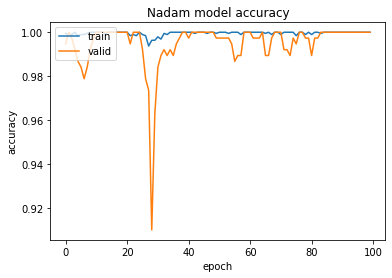

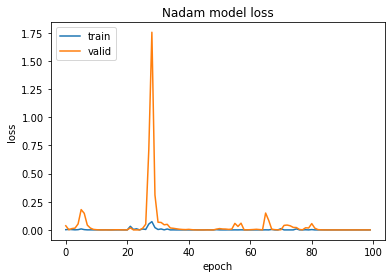

7/7 [==============================] - 5s 650ms/step
[1 2 0 1 0 0 0 2 1 2 2 2 2 2 0 1 2 0 2 2 0 0 2 1 1 0 1 2 0 0 0 2 1 1 1 0 1
 2 2 0 0 0 0 1 2 1 1 2 1 2 2 1 2 2 0 0 2 2 0 2 0 1 2 2 0 0 1 2 0 1 0 2 1 1
 2 1 0 1 2 0 2 1 1 2 2 2 0 0 0 1 2 1 0 2 1 1 2 0 0 2 2 0 0 1 1 1 2 1 1 1 2
 2 2 2 0 1 1 1 0 1 2 0 2 2 2 2 1 1 1 2 1 1 1 1 0 2 0 0 1 2 1 0 2 1 1 1 0 0
 1 2 1 1 1 1 0 1 2 2 0 1 1 0 1 0 2 2 2 0 2 1 2 1 1 1 0 0 1 0 0 2 1 1 2 0 0
 0 0 1 0 0 2 0 2 0 2 1 2 0 1 2 0 2 0 1 0 1 1 1 0 2 0 1 2 1 1 2 2 0 1 2 1 1
 0 0 0 2 2 2 1 1 0 0 2 0 1 0 0 2 1 0 2 0 1 1 0 2 2 0 0 0 2 1 1 1 0 2 1 0 1
 1 0 1 0 2 0 1 0 0 1 2 1 2 1 2 1 2 2 0 1 2 1 1 0 2 1 1 2 0 0 2 0 2 2 0 0 1
 0 1 1 1 1 1 0 0 2 2 1 1 1 1 0 1 0 2 1 1 2 1 0 2 1 2 0 2 2 2 1 1 0 0 0 2 2
 1 2 0 0 1 0 0 0 1 2 0 1 1 1 1 2 1 0 0 0 0 1 1 2 2 0 2 1 1 1 1 2 1 1 2 0 0
 2 2 0 2 0 0 0 2 1 0 1 0 2 0 2 2 1 0 2 1 1 2 1 1 2 2 2 0 0 0 0 1 1 1 1]
***Performance on Validation data***
Accuracy  : 0.31851851851851853
Precision : 0.3179593008889156
f1Score : 0.3179093041466

In [77]:
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('valid', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(sourcePath+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    sourcePath+'/valid/'+classLabel+'/'+X_val[eachIndex])
        
    train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64)
    valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64)
    test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64)

    history = model.fit(train_batches, 
                    validation_data=valid_batches,
                    epochs=100, 
                    verbose=2)
    
    model.evaluate(test_batches)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Nadam model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Nadam model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    predictions = model.predict(test_batches, verbose=1)
    yPredictions = np.argmax(predictions, axis=1)
    print(yPredictions)
    true_classes = test_batches.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)